In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import math

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import ScalarFormatter
import pickle
import sys
from pathlib import Path
sys.path.insert(0, "..")
from src.plot_util import (
    plot_U_V, plot_graded_overlapping_patches_df, plot_by_store_memberships, 
    plot_by_item_memberships, plot_store_sku_heatmap,
    plot_pca_explained_variance,
)   
from src.BinaryTriFactorizationEstimator import BinaryTriFactorizationEstimator, BinaryTriFactorizationMultiFeature


In [6]:
%load_ext autoreload
%autoreload 2

In [3]:
path = "../output/data/top_gc_median_df_model.pickle"
d = pickle.load(open(path, "rb"))
d

{'U': array([[1, 0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0],
        [1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 0, 1],
        [0, 0, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1],
        [0, 0, 0, 1, 0, 1]], dtype=int8),
 'V': array([[0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 1, 1],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 1],
        [0, 0, 0, 1, 1, 0],
        [1, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 1, 0]], dtype=int8),
 'B': array([[ 0.22423763,  0.0765989 ,  0.2670559 ,  0.14526592, -0.03965751,
          0.0601037 ],
        [ 0.25094033,  0.08406527,  0.19198848,  0.20102772,  0.22761201,
          0.12043506],
        [ 0.06653124,  0.08382656,  0.09359558,  0.18832404, -0.05184532,
          0.14608922],
        [-0.09831796,  0.13959467,  0.07228307,  0.08720251,  0.0144913 ,
          0.15990381],
        [

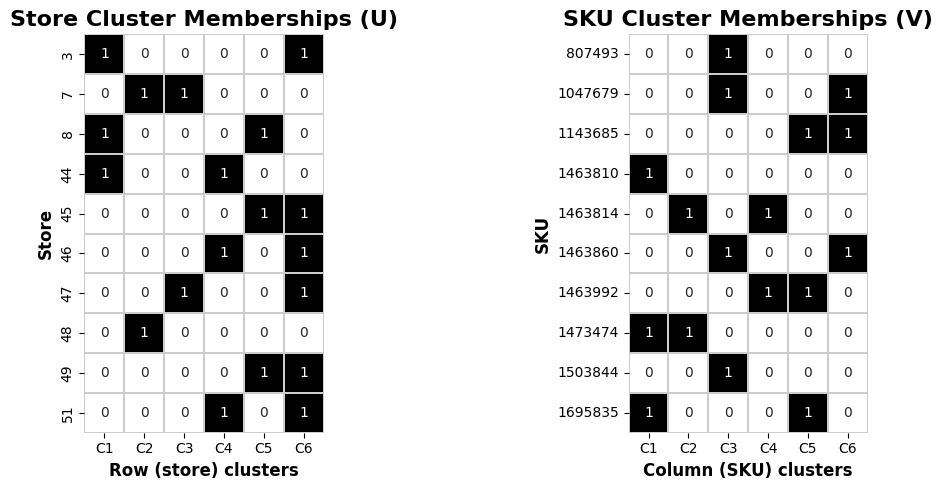

In [15]:
fn = Path("../output/figures/20251017_top_10_store_sku_U_V.tiff")
plot_U_V(
    d["U"], d["V"],
    d["row_names"],
    d["col_labels"],
    fn=fn,
)

In [4]:
X = pd.read_parquet("../output/data/top_gc_median_df.parquet")
X

item,807493,1047679,1143685,1463810,1463814,1463860,1463992,1473474,1503844,1695835
store,,,,,,,,,,
3,-0.100664,0.061644,-0.054486,-0.043037,-0.021405,-0.044905,0.013871,-0.000522,0.046514,0.003983
7,-0.109314,0.115150,0.045455,-0.045125,-0.031803,-0.054234,0.233440,-0.041476,-0.021727,-0.103444
8,0.018115,0.038688,-0.166921,-0.068142,-0.028743,0.033899,0.086899,-0.095203,-0.024563,-0.049717
44,-0.030781,-0.063654,-0.187821,-0.074568,-0.056228,0.081623,-0.060834,-0.069083,-0.028527,-0.168521
45,-0.088983,-0.233874,-0.083122,-0.087904,-0.043332,0.000011,-0.024241,-0.061894,-0.015947,0.030688
46,-0.271890,-0.028522,-0.070456,-0.116117,-0.042809,-0.051641,0.005644,-0.058991,0.062415,-0.140928
47,-0.088254,0.097213,-0.155522,-0.040284,-0.014005,-0.012556,-0.059407,-0.024887,-0.014068,-0.071948
48,-0.113193,0.001798,-0.179010,-0.080971,-0.096480,0.060771,-0.019310,-0.023916,0.023689,-0.064514
49,-0.180963,0.017268,-0.090216,-0.042243,-0.056762,0.106379,0.004434,-0.081315,-0.023470,0.026916


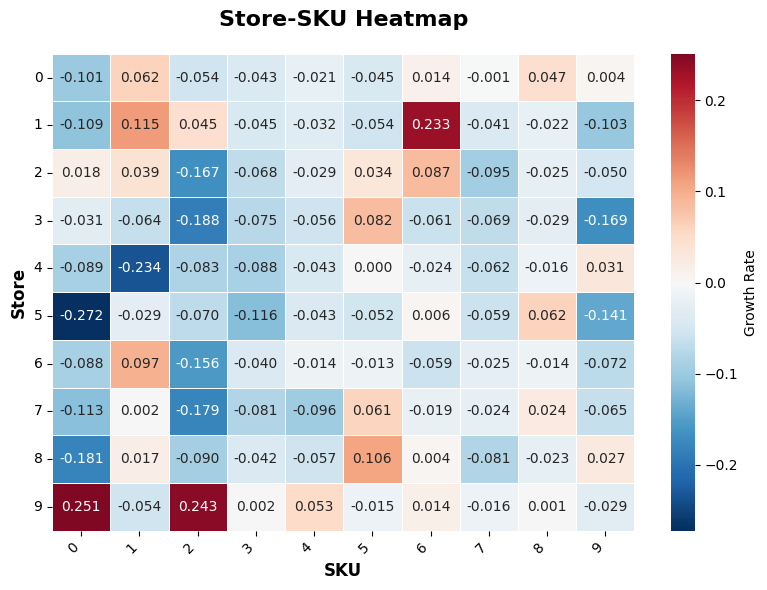

In [5]:
plot_store_sku_heatmap(X)

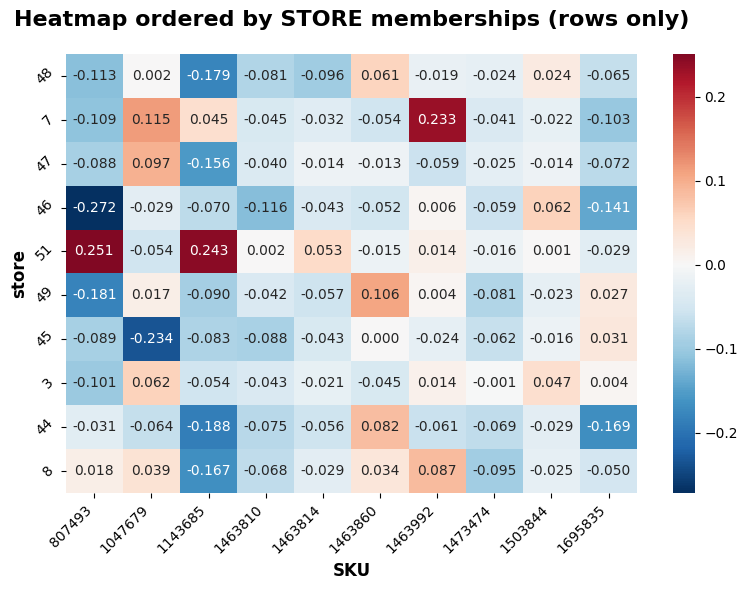

In [16]:
# 1) Reorder by stores only (U); keep columns as-is
fn = Path("../output/figures/20251017_heatmap_top_10_store_item_item_clusters_matrix.png")
plot_by_store_memberships(X, d["U"], show_values=True, value_fmt=".3f", fn=fn)



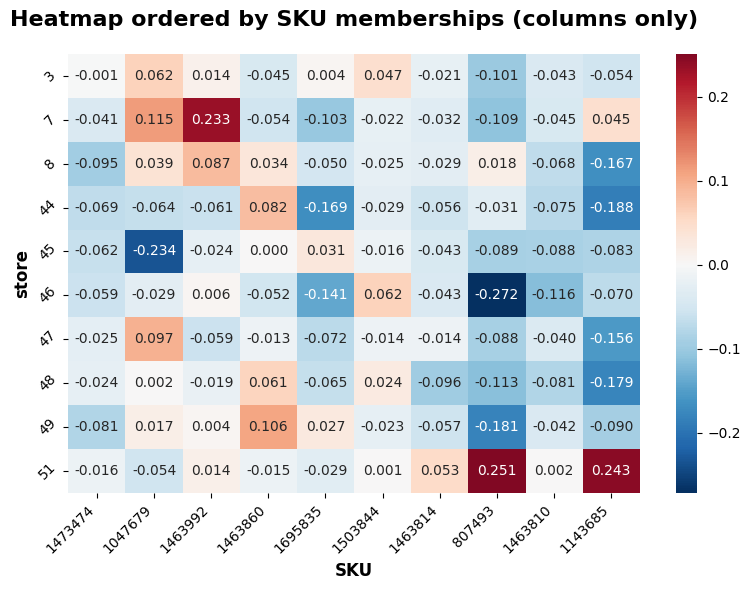

In [17]:
fn = Path("../output/figures/20251017_heatmap_top_10_store_item_item_clusters_matrix.png")
plot_by_item_memberships(X, d["U"], show_values=True, value_fmt=".3f", fn=fn)


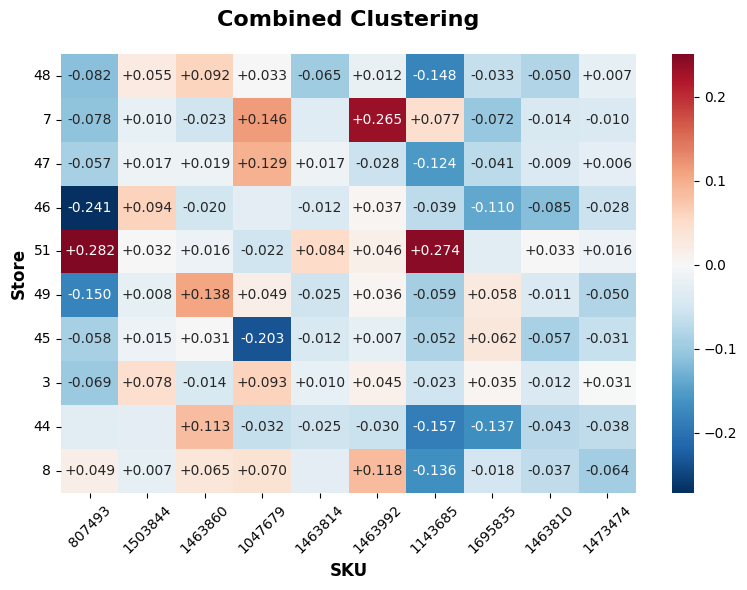

In [24]:
fn = Path("../output/figures/20251020_heatmap_top_10_store_item_graded_clusters_matrix.png")
plot_graded_overlapping_patches_df(
    X, d["U"], d["V"],
    cmap="RdBu_r",
    annotate="abs",
    min_abs=0.005,
    fn=fn,
)

In [4]:
from src.data_utils import load_xtensor_npz

In [5]:
fn = Path("../output/data/Xtensor_2025-10-22_10x10x9.npz")

X, M, stores, items, features = load_xtensor_npz(
    fn
)


In [6]:
np.isfinite(M)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])

In [7]:
X.shape

(10, 10, 9)

In [8]:
for d, nm in enumerate(features):
    n_obs = np.sum(~np.isnan(X[:, :, d]))
    print(f"{nm:18s} observed cells: {n_obs}")

feature_weights = np.array([
    1, # gr_median
    1,  # gr_std
    1,  # gr_iqr
    1,  # frac_up
    1,  # frac_sideways
    1,  # frac_down
    1,   # up_to_down_ratio
    1,  # ac_lag1
    1,  # ac_lag4
])

# 2) Optionally drop truly-empty channels before fitting
keep = np.array([~np.isnan(X[:, :, d]).all() for d in range(X.shape[2])])
X = X[:, :, keep]
features = [f for f, k in zip(features, keep) if k]
feature_weights = feature_weights[keep]
features


gr_median          observed cells: 100
gr_std             observed cells: 100
gr_iqr             observed cells: 100
frac_up            observed cells: 100
frac_sideways      observed cells: 100
frac_down          observed cells: 100
up_to_down_ratio   observed cells: 100
ac_lag1            observed cells: 100
ac_lag4            observed cells: 100


['gr_median',
 'gr_std',
 'gr_iqr',
 'frac_up',
 'frac_sideways',
 'frac_down',
 'up_to_down_ratio',
 'ac_lag1',
 'ac_lag4']

In [ ]:

est = BinaryTriFactorizationMultiFeature(
    n_row_clusters=5, 
    n_col_clusters=5,
    feature_weights=feature_weights,
    alpha=1e-3, beta=1e-3
)
est.history_flag = True 
est.fit(X)

BinaryTriFactorizationMultiFeature(n_row_clusters=5, n_col_clusters=5, k_row=None, k_col=None, loss=gaussian, alpha=0.001, beta=0.001, max_iter=30, tol=0.0001, random_state=0)

In [10]:
U, Bvec, V = est.factors()      # U:(I,R), Bvec:(R,C,D), V:(J,C)
Xhat = est.reconstruct()        # (I,J,D)

# overall RSS/RMSE/PVE over all entries
rss = float(((X - Xhat)**2).sum())
rmse = (rss / X.size) ** 0.5
mu = float(X.mean()); eps = 1e-12
pve = 100 * (1 - ((X - Xhat)**2).sum() / max(((X - mu)**2).sum(), eps))
print(f"RMSE={rmse:.4f}, PVE={pve:.2f}%")


RMSE=0.7458, PVE=48.68%


In [11]:
print(U.shape)
print(Bvec.shape)
print(V.shape)

(10, 5)
(5, 5, 9)
(10, 5)


In [22]:
def plot_reconstruction_quality_3d(
    est,
    X,
    *,
    M=None,                      # (I,J) True = observed; if None, fall back to ~np.isnan per feature
    features=None,
    feature_for_heatmap: int = 0,
    show_pve_line: bool = True,
    use_rmse: bool = True,
    max_scatter_points: int = 200_000,
    store_names=None,           # list/array length I
    item_names=None,            # list/array length J  (SKUs)
    max_labels: int = 50,       # cap total tick labels per axis
    tick_step: int | None = None,  # force a step if you want; overrides max_labels
    fn: Path | None = None,
    figsize=(12, 8)
):
    X = np.asarray(X)
    assert X.ndim == 3, f"Expected (I,J,D), got {X.shape}"
    I, J, D = X.shape
    names = list(features) if features is not None else [f"feat_{d}" for d in range(D)]

    X_rec = est.reconstruct()
    if X_rec.shape != X.shape:
        raise ValueError(f"X_rec shape {X_rec.shape} != X shape {X.shape}")

    # --- Build masks ---
    if M is not None:
        assert M.shape == (I, J), f"M must be (I,J), got {M.shape}"
        Md = np.repeat(M[:, :, None], D, axis=2)  # (I,J,D)
    else:
        # fall back: observed if not NaN in that feature channel
        Md = ~np.isnan(X)

    # --- Scatter over observed elements only ---
    x_flat  = X[Md]
    xr_flat = X_rec[Md]
    n = x_flat.size
    if n > max_scatter_points:
        idx = np.random.RandomState(0).choice(n, size=max_scatter_points, replace=False)
        x_plot, xr_plot = x_flat[idx], xr_flat[idx]
    else:
        x_plot, xr_plot = x_flat, xr_flat

    # --- Per-feature metrics on observed cells only ---
    n_total = I * J
    n_obs_per = np.zeros(D, dtype=int)
    coverage = np.zeros(D, dtype=float)
    rss_per = np.full(D, np.nan)
    rmse_per = np.full(D, np.nan)
    pve_per = np.full(D, np.nan)

    for d in range(D):
        md = Md[:, :, d]
        n_obs = int(md.sum())
        n_obs_per[d] = n_obs
        coverage[d] = (n_obs / n_total) if n_total > 0 else 0.0
        if n_obs == 0:
            continue
        xd  = X[:, :, d][md]
        xhd = X_rec[:, :, d][md]
        resid = xd - xhd
        rss = float(np.sum(resid * resid))
        rss_per[d] = rss
        rmse_per[d] = float(np.sqrt(rss / n_obs))
        mu = float(xd.mean()); tss = float(np.sum((xd - mu) ** 2))
        pve_per[d] = (1.0 - rss / max(tss, 1e-12)) * 100.0 if tss > 0 else np.nan

    # --- Residual heatmap for selected feature (observed cells only) ---
    fidx = int(np.clip(feature_for_heatmap, 0, D - 1))
    md_hm = Md[:, :, fidx]
    residual_2d = np.full((I, J), np.nan)
    if md_hm.any():
        residual_2d[md_hm] = X[:, :, fidx][md_hm] - X_rec[:, :, fidx][md_hm]
    vmax = np.nanmax(np.abs(residual_2d))
    vmin = -vmax if np.isfinite(vmax) else -1.0
    
    # --- Figure layout ---
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # 1) Scatter
    ax = axes[0, 0]
    if x_plot.size > 0:
        ax.scatter(x_plot, xr_plot, alpha=0.35, s=2)
        lo, hi = float(np.nanmin(x_plot)), float(np.nanmax(x_plot))
        ax.plot([lo, hi], [lo, hi], "r--", lw=1)
    ax.set_xlabel("Original values"); ax.set_ylabel("Reconstructed values")
    ax.set_title("Reconstruction scatter (observed cells)"); ax.grid(True, alpha=0.2)

    # 2) Per-feature bars with explicit coverage labels
    ax = axes[0, 1]
    xloc = np.arange(D)
    vals = rmse_per if use_rmse else rss_per
    label = "RMSE" if use_rmse else "RSS"

    # draw bars, but keep NaNs as NaNs so we can style them
    heights = np.array([v if np.isfinite(v) else 0.0 for v in vals], dtype=float)
    bars = ax.bar(xloc, heights)

    # style & annotate
    y_max = (np.nanmax(heights) if np.isfinite(np.nanmax(heights)) else 1.0)
    for d, b in enumerate(bars):
        if not np.isfinite(vals[d]) or n_obs_per[d] == 0:
            # no observed data: gray hatched bar at tiny height
            b.set_height(0.02 * y_max)
            b.set_color("lightgray")
            b.set_hatch("//")
            ax.text(b.get_x() + b.get_width()/2.0, b.get_height(),
                    "no data", ha="center", va="bottom", fontsize=9, color="dimgray")
        # coverage label: obs/total
        ax.text(b.get_x() + b.get_width()/2.0,
                b.get_height(),
                f"{n_obs_per[d]}/{n_total}",
                ha="center", va="bottom", fontsize=9, color="black", alpha=0.9)

    ax.set_xticks(xloc)
    ax.set_xticklabels(names, rotation=45, ha="right")
    ax.set_ylabel(label)
    ax.set_title(f"Per-feature {label}")

    if show_pve_line:
        ax2 = ax.twinx()
        ok = np.isfinite(pve_per)
        ax2.plot(xloc[ok], pve_per[ok], marker="o", lw=1)
        ax2.set_ylabel("PVE (%)"); ax2.set_ylim(0, 100)

    # 3) Residual heatmap
    ax = axes[1, 0]
    im = ax.imshow(residual_2d, cmap="RdBu_r", vmin=vmin, vmax=vmax, aspect="auto")
    
    def _apply_ticks(ax, N, names, axis: str):
        if names is None:
            return
        names = list(map(str, names))
        if tick_step is not None and tick_step > 0:
            step = tick_step
        else:
            # choose step so we don't exceed max_labels
            step = max(1, math.ceil(N / max_labels))
        idxs = list(range(0, N, step))
        if axis == "x":
            ax.set_xticks(idxs)
            ax.set_xticklabels([names[k] for k in idxs], rotation=45, ha="right", fontsize=8)
        else:
            ax.set_yticks(idxs)
            ax.set_yticklabels([names[k] for k in idxs], fontsize=8)

    _apply_ticks(ax, I, store_names, axis="y")
    _apply_ticks(ax, J, item_names,  axis="x")
        
    ax.set_title(f"Residuals — {names[fidx]}")
    ax.set_xlabel("SKU" if item_names is not None else "SKU (J)")
    ax.set_ylabel("Store" if store_names is not None else "Store (I)")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # 4) Convergence
    ax = axes[1, 1]
    if getattr(est, "loss_history_", None) and len(est.loss_history_) > 0:
        ax.plot(est.loss_history_, label="Objective", lw=1.5)
        ax.legend()
        ax.set_yscale("log")
        # 1. Create a ScalarFormatter instance
        formatter = ScalarFormatter(useOffset=False, useMathText=False)
        formatter.set_scientific(False) # Explicitly turn off scientific notation
        
        # 2. Apply the formatter to both major and minor ticks
        ax.yaxis.set_major_formatter(formatter)
        ax.yaxis.set_minor_formatter(formatter)
        
        # Optional: Force showing all ticks/labels clearly
        ax.tick_params(axis='y', which='both', labelrotation=0)
    else:
        ax.text(0.5, 0.5, "No history to plot.\nEnable recording in fit().",
                ha="center", va="center", fontsize=10, transform=ax.transAxes)
    ax.set_xlabel("Iteration");
    ax.set_ylabel("Loss")
    ax.set_title("Training convergence"); ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(fn, dpi=300)
    plt.show()
    plt.close(fig)


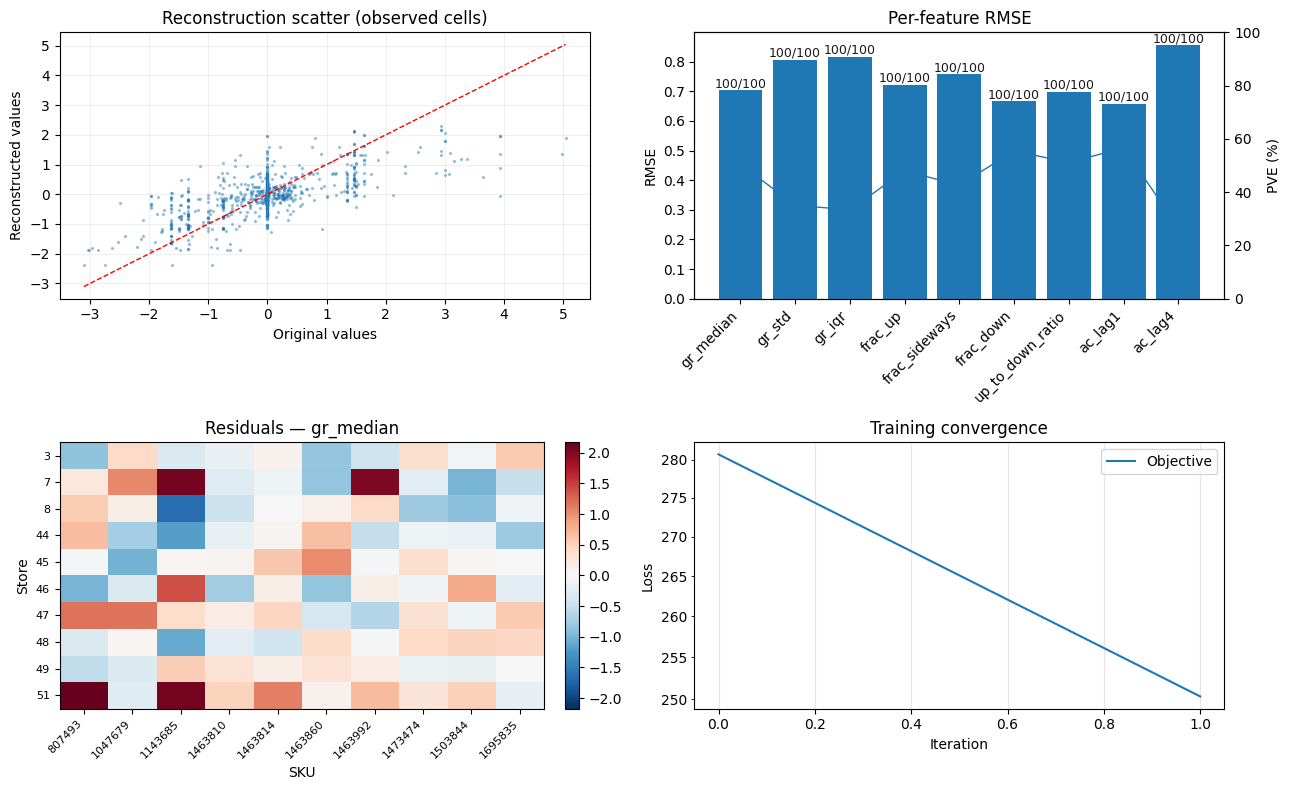

In [24]:
features = ["gr_median","gr_std","gr_iqr",
            "frac_up","frac_sideways","frac_down","up_to_down_ratio",
            "ac_lag1","ac_lag4"]
path = Path("../output/figures/20251017_top_10_store_sku_reconstruction_quality.tiff")
fig = plot_reconstruction_quality_3d(
    est=est,
    X=X,
    M=M,
    features=features,            # optional list of names
    feature_for_heatmap=0,        # pick which channel to visualize
    show_pve_line=True,
    use_rmse=True,
    store_names=stores,          # your store name vector, len I
    item_names=items,
    figsize=(13, 8),
    fn=path,
)


In [3]:
path = "../output/data/2014_January_top_53_store_2000_item_growth_rate_imputed_features.parquet"
df = pd.read_parquet(path)
df.head()

,store_item,gr_median,gr_std,gr_iqr,frac_up,frac_sideways,frac_down,up_to_down_ratio,ac_lag1,ac_lag4
0,10_1000866,-0.047619,0.459630,0.520833,0.50,0.0,0.50,1.000000,0.474464,-0.5
1,10_1001305,-0.047619,0.459630,0.520833,0.50,0.0,0.50,1.000000,0.474464,-0.5
2,10_1003679,-0.081169,0.301891,0.195860,0.25,0.0,0.75,0.333333,-0.797224,-0.5
3,10_1004545,-0.047619,0.459630,0.520833,0.50,0.0,0.50,1.000000,0.474464,-0.5
4,10_1004550,-0.107143,2.378891,2.375000,0.50,0.0,0.50,1.000000,-0.899349,-0.5


In [4]:
features = ["gr_median","gr_std","gr_iqr",
            "frac_up","frac_sideways","frac_down","up_to_down_ratio",
            "ac_lag1","ac_lag4"]
X_mat, M, row_names, col_names = build_multifeature_X_matrix(
            df, features
)
# fn = Path("../output/figures/20251028_pca_explained_variance.tiff")
# plot_pca_explained_variance(X_mat, fn=fn)

In [5]:
del df

In [6]:
def center_scale_signed(X, M, eps=1e-8):
    """
    Z-score each feature using only observed entries; then fill missing with 0,
    which is the feature mean after centering.
    """
    Xcs = X.copy()
    I, J, D = X.shape
    mus = np.zeros(D); sds = np.ones(D)
    for d in range(D):
        vals = Xcs[..., d][M]
        mu = np.nanmean(vals)
        sd = np.nanstd(vals, ddof=1);  sd = sd if sd > eps else 1.0
        Xcs[..., d] = (Xcs[..., d] - mu) / sd
        mus[d] = mu; sds[d] = sd
    # Neutral imputation after centering
    Xcs[~M, :] = 0.0
    return Xcs, mus, sds

def pve(X, Xhat):
    num = np.linalg.norm(X - Xhat)**2
    den = np.linalg.norm(X)**2 + 1e-12
    return 1.0 - num/den


In [7]:
import tensorly as tl
from tensorly.decomposition import tucker
tl.set_backend("numpy")
(rI, rJ, rK) = (12, 12, 40)

Xcs, mus, sds = center_scale_signed(X_mat, M)
core, factors = tucker(tl.tensor(Xcs), rank=[rI, rJ, rK], init='svd', tol=1e-6, n_iter_max=500)
Xhat = tl.tucker_to_tensor((core, factors))
print("PVE:", pve(Xcs, Xhat))

# U, V, W = (np.asarray(f) for f in factors)  # shapes: (I,rI), (J,rJ), (K,40)

# # Soft memberships (overlapping)
# U_soft = U / (np.sum(np.abs(U), axis=1, keepdims=True) + 1e-12)
# V_soft = V / (np.sum(np.abs(V), axis=1, keepdims=True) + 1e-12)
# # Example overlap rule: top-2 components per row
# def top_m(M, m=2):
#     out = np.zeros_like(M, dtype=int)
#     idx = np.argpartition(-np.abs(M), kth=m-1, axis=1)[:, :m]
#     rows = np.arange(M.shape[0])[:, None]
#     out[rows, idx] = 1
#     return out
# U_multi = top_m(U_soft, m=2)
# V_multi = top_m(V_soft, m=2)


: 

In [2]:
path = Path("../output/data/2014_January_top_53_store_2000_item_growth_rate_clusters.csv")
df = pd.read_csv(path)
df.head()

/var/folders/w3/d06m5l_97yn4bnxd5t6cgbjr0000gn/T/ipykernel_98539/2586206105.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


,factor_name,item_name,cluster_id
0,Store,1,2
1,Store,1,6
2,Store,1,4
3,Store,1,8
4,Store,1,5


In [ ]:


# First, count how many clusters each item belongs to
cluster_counts = df.groupby(['factor_name', 'item_name']).size().reset_index(name='num_clusters')

# Then calculate statistics by factor_name
stats = cluster_counts.groupby('factor_name')['num_clusters'].agg([
    'min', 
    'mean', 
    'max',
    lambda x: np.percentile(x, 75) - np.percentile(x, 25)  # IQR
]).round(2)

# Rename the lambda column to IQR
stats = stats.rename(columns={'<lambda_0>': 'IQR'})
stats

             min    mean  max  IQR
factor_name                       
Feature        3    4.22    6  2.0
SKU           66  190.90  209  6.0
Store         22   24.72   27  2.0


In [7]:
path = Path("../output/data/20251004_NTF_2014_January_top_53_store_2000_item_growth_rate_clusters.csv")
df = pd.read_csv(path)
df.head()

,factor_name,item_name,cluster_id
0,Store,1,43
1,Store,1,80
2,Store,1,33
3,Store,1,69
4,Store,1,68


In [8]:


# First, count how many clusters each item belongs to
cluster_counts = df.groupby(['factor_name', 'item_name']).size().reset_index(name='num_clusters')

# Then calculate statistics by factor_name
stats = cluster_counts.groupby('factor_name')['num_clusters'].agg([
    'min', 
    'mean', 
    'max',
    lambda x: np.percentile(x, 75) - np.percentile(x, 25)  # IQR
]).round(2)

# Rename the lambda column to IQR
stats = stats.rename(columns={'<lambda_0>': 'IQR'})
stats

,min,mean,max,IQR
factor_name,,,,
Feature,4,30.67,62,34.00
SKU,31,66.13,85,10.25
Store,5,10.79,20,4.50


In [9]:
path = Path("../output/data/20251004_PARAFAC_2014_January_top_53_store_2000_item_growth_rate_clusters.csv")
df = pd.read_csv(path)
df.head()

,factor_name,item_name,cluster_id
0,Store,1,24
1,Store,1,18
2,Store,1,25
3,Store,1,56
4,Store,1,75


In [10]:


# First, count how many clusters each item belongs to
cluster_counts = df.groupby(['factor_name', 'item_name']).size().reset_index(name='num_clusters')

# Then calculate statistics by factor_name
stats = cluster_counts.groupby('factor_name')['num_clusters'].agg([
    'min', 
    'mean', 
    'max',
    lambda x: np.percentile(x, 75) - np.percentile(x, 25)  # IQR
]).round(2)

# Rename the lambda column to IQR
stats = stats.rename(columns={'<lambda_0>': 'IQR'})
stats

,min,mean,max,IQR
factor_name,,,,
Feature,95,111.22,125,22.0
SKU,85,95.28,106,4.0
Store,88,95.38,102,5.0
